# From Merged Raw Data to Project Data

- From merged dataset to project specific dataset
- Here filtering by cruise name
- Export and Save Files
- pull in collapseNoMismatch processed data (Dada2 program)
- pull in latest Metadata Sheets from /MBON
- For CN19S, remove final drift samples from ESP samples

### Imports

In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import glob

#For illustrator import:
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

### Functions

In [2]:
# Dada2 Banzai Output Functions
levels = ['Kingdom', 'Phylum', 'Class', 'Order', 'Family', 'Genus', 'Species']

def make_metadata(infile):
    df = pd.read_csv(infile)
    df.set_index('sample_name', inplace=True)
    return df

#Raw Read Numbers
def make_taxa_otu_tables(infile):
    #infile = ASV_taxa_table_all.csv
    df = pd.read_csv(infile, sep=',')
    df.set_index('ASV', inplace=True)
    otu_table = df.drop(levels, axis=1)
    taxa_table = df[levels]
    return otu_table, taxa_table

#From fasta file create pandas df of ASV and sequence
def from_fasta_to_df(file):
    print(file)
    with open(file) as f:
        Ids=[]
        seqs =[]
        for strline in f:
            if strline[0]=='>':
                Ids.append(strline[1:].strip())
            else:
                seqs.append(strline.strip())
    print('Number of Ids:',len(Ids))
    print('Number of Seqs:',len(seqs))
    seq_dict = dict(zip(Ids, seqs))
    #make pandas df
    df= pd.DataFrame.from_dict(seq_dict,orient='index', columns=['sequence'])
    return df

#from metadata file, limit OTU table and taxa table to those present in those samples
def from_metadata_to_taxareads(meta_data, otu_table, taxa_table):
    #standard M6 output; sample_names as index; OTUs as index
    cols = list(meta_data)
    otu_lim = pd.concat([meta_data, otu_table.T],join='inner', axis=1)
    otu_lim.drop(cols, inplace=True, axis=1)
    otu_lim=otu_lim.T
    otu_lim['Total']=otu_lim.sum(axis=1)
    otu_lim = otu_lim.loc[otu_lim['Total']>0]
    otu_lim.drop('Total', axis=1, inplace=True)
    cols=list(otu_lim)
    taxa_lim=pd.concat([otu_lim, taxa_table], axis=1, join='inner')
    taxa_lim.drop(cols, inplace=True, axis=1)
    return otu_lim, taxa_lim

def from_taxa_to_otutab(taxa_table, otu_table):
    #remove OTUs not in the taxa table
    otu_lim = pd.concat([taxa_table, otu_table],join='inner', axis=1)
    otu_lim.drop(levels, inplace=True, axis=1)
    return otu_lim

In [3]:
# USE CN19 specific metadata
file = '/Users/kpitz/github/MBARI-BOG/CN19S_12S/data/metadata/CN19all_CTD_ESP_sequenced_metadata_050321_annotated.csv'

df = pd.read_csv(file)
#df.drop('Unnamed: 0', axis=1, inplace=True)
df.set_index('FilterID', inplace=True)
CN19_meta = df.copy()
df.head()

,local_time,time_label,SAMPLING_cruise,depth,SAMPLING_platform,SC,ESP,SAMPLING_station_number,SAMPLING_station,SAMPLING_bottle,...,chlorophyll,bbp470 (count),bbp650 (count),SAMPLING_project,ESP_name,diel,month,day,hour,eventDate
FilterID,,,,,,,,,,,,,,,,,,,,,
CN19SESPMV1_SC05_eDNA,5/23/19 13:23,05-23 day,CN19S,37.4937,daphne,5.0,MV1,NaN,NaN,NaN,...,0.4550,77.1869,66.4030,CANON,NaN,day,5.0,23.0,13.0,5/23/19 20:23
CN19SESPMV1_SC04_eDNA,5/23/19 14:01,05-23 day,CN19S,207.6086,daphne,4.0,MV1,NaN,NaN,NaN,...,0.1225,74.9326,61.6372,CANON,NaN,day,5.0,23.0,14.0,5/23/19 21:01
CN19SESPMV1_SC03_eDNA,5/23/19 14:31,05-23 day,CN19S,277.4200,daphne,3.0,MV1,NaN,NaN,NaN,...,0.1300,75.1930,61.9366,CANON,NaN,day,5.0,23.0,14.0,5/23/19 21:31
CN19SESPMV1_SC58_eDNA,5/29/19 2:42,05-29 night,CN19S,17.6279,daphne,58.0,MV1,NaN,NaN,NaN,...,2.7972,100.9675,109.2667,CANON,NaN,night,5.0,29.0,2.0,5/29/19 9:42
CN19SESPKOA_SC58_eDNA,5/29/19 12:32,05-29 day,CN19S,32.5799,makai,58.0,KOA,NaN,NaN,NaN,...,0.5502,83.3809,149.0871,CANON,NaN,day,5.0,29.0,12.0,5/29/19 19:32


# Just 12S

In [4]:
marker = '12S'

print('#####' +marker + '#####')

directory = '/Volumes/MBON/processed/banzai_Dada2/12S/Merged_dataset/Results_20220824/'
plot_dir = '/Users/kpitz/github/MBARI-BOG/CN19S_12S/figures/'
print(plot_dir)

#####12S#####
/Users/kpitz/github/MBARI-BOG/CN19S_12S/figures/


In [6]:
# otu table
file = 'Collapsed_ASV_table_unfiltered.csv'
print(directory+file)
df = pd.read_csv(directory + file)
df.set_index('ASV', inplace=True)
otu_all = df.copy()
print('Number ASVs:', len(df.index))

# taxa table
file = 'Collapsed_taxa_table_unfiltered.csv'
df = pd.read_csv(directory+file)
df.set_index('ASV', inplace=True)
taxa_all = df.copy()
print('Number ASVs:', len(df.index))

# metadata
file = 'Collapsed_meta_table_unfiltered.csv'
df = pd.read_csv(directory+file)
df.set_index('sample_name', inplace=True)
meta_all = df.copy()
print('Number samples:', len(df.index))

# sequence table
file = 'Collapsed_seq_table_unfiltered.csv'
df = pd.read_csv(directory +file)
df.set_index('ASV', inplace=True)
seq_all = df.copy()
print('Number ASVs:', len(df.index))

/Volumes/MBON/processed/banzai_Dada2/12S/Merged_dataset/Results_20220824/Collapsed_ASV_table_unfiltered.csv
Number ASVs: 36163
Number ASVs: 36163
Number samples: 2841
Number ASVs: 36163


In [7]:
# CN19S libraries for paper
libs = ['BT', 'CE', 'JJ', 'RR']

### Make Project Metadata

- No ESP drift samples (at end of deployment)
- Don't include ROV samples

In [13]:
# USE CN19 specific metadata
file = '/Users/kpitz/github/MBARI-BOG/CN19S_12S/data/metadata/CN19all_CTD_ESP_sequenced_metadata_050321_annotated.csv'

df = pd.read_csv(file)
#df.drop('Unnamed: 0', axis=1, inplace=True)
df.set_index('FilterID', inplace=True)
CN19_meta = df.copy()
df.head()

,local_time,time_label,SAMPLING_cruise,depth,SAMPLING_platform,SC,ESP,SAMPLING_station_number,SAMPLING_station,SAMPLING_bottle,...,chlorophyll,bbp470 (count),bbp650 (count),SAMPLING_project,ESP_name,diel,month,day,hour,eventDate
FilterID,,,,,,,,,,,,,,,,,,,,,
CN19SESPMV1_SC05_eDNA,5/23/19 13:23,05-23 day,CN19S,37.4937,daphne,5.0,MV1,NaN,NaN,NaN,...,0.4550,77.1869,66.4030,CANON,NaN,day,5.0,23.0,13.0,5/23/19 20:23
CN19SESPMV1_SC04_eDNA,5/23/19 14:01,05-23 day,CN19S,207.6086,daphne,4.0,MV1,NaN,NaN,NaN,...,0.1225,74.9326,61.6372,CANON,NaN,day,5.0,23.0,14.0,5/23/19 21:01
CN19SESPMV1_SC03_eDNA,5/23/19 14:31,05-23 day,CN19S,277.4200,daphne,3.0,MV1,NaN,NaN,NaN,...,0.1300,75.1930,61.9366,CANON,NaN,day,5.0,23.0,14.0,5/23/19 21:31
CN19SESPMV1_SC58_eDNA,5/29/19 2:42,05-29 night,CN19S,17.6279,daphne,58.0,MV1,NaN,NaN,NaN,...,2.7972,100.9675,109.2667,CANON,NaN,night,5.0,29.0,2.0,5/29/19 9:42
CN19SESPKOA_SC58_eDNA,5/29/19 12:32,05-29 day,CN19S,32.5799,makai,58.0,KOA,NaN,NaN,NaN,...,0.5502,83.3809,149.0871,CANON,NaN,day,5.0,29.0,12.0,5/29/19 19:32


In [ ]:
#  cols = ['FilterID','SAMPLING_cruise','SAMPLING_station_number','SAMPLING_bottle','sample_type', 'SAMPLING_platform','ESP', 'SC', 'PlateID', 'target_gene']


['BT', 'CE', 'JJ', 'RR']
sample_types: ['negative' 'environmental' 'positive' 'MSU_control']
CONTROLS:: Index(['V4195_CB_eDNA_BT', 'CN19F_CB_V4216_BT', 'CN19F_CB_V4217_BT',
       'V4196_CB_eDNA_BT', 'CN19S_CN19F_EB1_BT', 'Art_Com1_BT',
       'PCR_Blank1_BT', 'RTSF_NTC_1233_BT', 'pcrblank1_RR', 'pcrblank2_RR',
       'ArtComm1_RR', '20191203_EB_RR', 'pcrblank3_RR', 'pcrblank_1_JJ',
       'pcrblank_2_JJ', '20191022_EB_JJ', 'Artcomm2_JJ', 'pcrblank_3_JJ',
       'pcrblank1_CE', 'pcrblank2_CE', 'pcrblank3_CE', 'ArtComm1_CE',
       'ArtComm2_CE', 'CN19SP3_OSU_EB1_CE', 'CN19SP3_OSU_EB2_CE',
       'RTSF_NTC_1284_CE'],
      dtype='object', name='sample_name')
               FilterID   DUP
sample_name                  
pcrblank1_RR  pcrblank1  True
pcrblank2_RR  pcrblank2  True
ArtComm1_RR    ArtComm1  True
pcrblank3_RR  pcrblank3  True
pcrblank1_CE  pcrblank1  True
pcrblank2_CE  pcrblank2  True
pcrblank3_CE  pcrblank3  True
ArtComm1_CE    ArtComm1  True
/Users/kpitz/github/MBARI-BOG/CN19

/var/folders/5v/h4s_0pz17yb6f6krsxkzr5dw000b65/T/ipykernel_1598/301037063.py:22: FutureWarning: The default value of regex will change from True to False in a future version.
  df['FilterID'] = df['FilterID'].str.replace('koa|Koa','KOA')


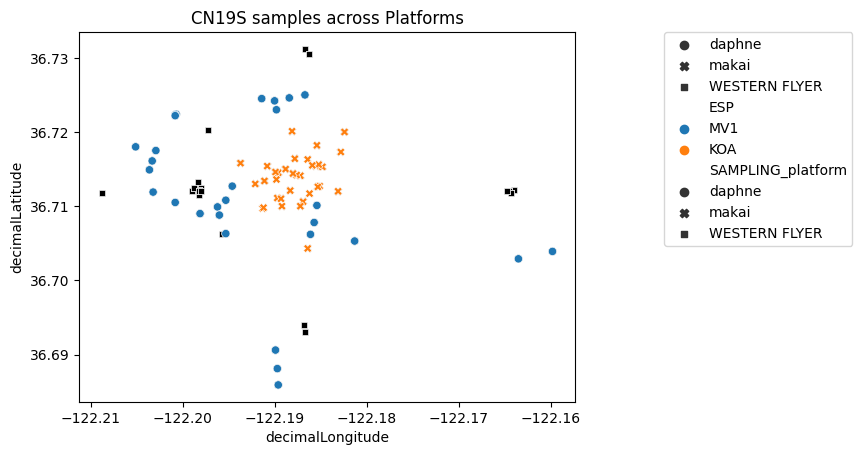

Number of samples: 286
['FilterID', 'target_gene', 'PlateID', 'library', 'local_time', 'time_label', 'SAMPLING_cruise', 'depth', 'SAMPLING_platform', 'SC', 'ESP', 'SAMPLING_station_number', 'SAMPLING_station', 'SAMPLING_bottle', 'decimalLongitude', 'decimalLatitude', 'sample_type', 'Plates', 'Markers', 'Status', 'Dewar_name', 'Sampling_method', 'replicate', 'SAMPLING_rdepth', 'project_name', 'nitrate', 'fluor', 'density', 'pressure', 'minimumDepthInMeters', 'maximumDepthInMeters', 'start_GMT', 'end_GMT', 'temp', 'salinity', 'sigmat', 'spice', 'diss_oxygen', 'PAR (umol/s/m2)', 'altitude', 'chlorophyll', 'bbp470 (count)', 'bbp650 (count)', 'SAMPLING_project', 'ESP_name', 'diel', 'month', 'day', 'hour', 'eventDate']


,FilterID,target_gene,PlateID,library,local_time,time_label,SAMPLING_cruise,depth,SAMPLING_platform,SC,...,chlorophyll,bbp470 (count),bbp650 (count),SAMPLING_project,ESP_name,diel,month,day,hour,eventDate
sample_name,,,,,,,,,,,,,,,,,,,,,
CN19SESPMV1_SC58_eDNA_CE,CN19SESPMV1_SC58_eDNA,12S,CE,CE40,2019-05-29 02:42:00,05-29 night,CN19S,17.6279,daphne,58.0,...,2.7972,100.9675,109.2667,CANON,NaN,night,5.0,29.0,2.0,5/29/19 9:42
CN19SESPKOA_SC58_eDNA_CE,CN19SESPKOA_SC58_eDNA,12S,CE,CE3,2019-05-29 12:32:00,05-29 day,CN19S,32.5799,makai,58.0,...,0.5502,83.3809,149.0871,CANON,NaN,day,5.0,29.0,12.0,5/29/19 19:32
CN19SESPKOA_SC57_eDNA_CE,CN19SESPKOA_SC57_eDNA,12S,CE,CE4,2019-05-29 13:47:00,05-29 day,CN19S,202.5248,makai,57.0,...,0.0782,78.4872,146.0477,CANON,NaN,day,5.0,29.0,13.0,5/29/19 20:47
CN19SESPKOA_SC56_eDNA_CE,CN19SESPKOA_SC56_eDNA,12S,CE,CE5,2019-05-29 14:50:00,05-29 day,CN19S,267.6256,makai,56.0,...,0.0833,78.2715,148.8699,CANON,NaN,day,5.0,29.0,14.0,5/29/19 21:50
CN19SESPKOA_SC55_eDNA_CE,CN19SESPKOA_SC55_eDNA,12S,CE,CE6,2019-05-29 23:17:00,05-29 night,CN19S,27.4770,makai,55.0,...,0.3254,80.2178,143.2971,CANON,NaN,night,5.0,29.0,23.0,5/30/19 6:17


In [29]:
# Start with large merged metadata file:

df = meta_all.copy()

#Just the right libraries:
print(libs)
df = df.loc[df['PlateID'].isin(libs)==True]

# make sure target_gene field exists, create FilterID by dropping off PlateID from sample name
df['target_gene'] = marker
df['FilterID'] = df.index.str.split('_').str[:-1]
df['FilterID'] = df['FilterID'].str.join('_')

#make sure match current standards:
#fix no single digit CTD bottle numbers
for i in range(1,10):
    #print(i)
    z = str(i)
    df['FilterID'] = df['FilterID'].str.replace('_'+z+'_','_0'+z+'_' )

#fix ESP names
df['FilterID'] = df['FilterID'].str.replace('koa|Koa','KOA')

#Get the control samples:
print('sample_types:',df['sample_type'].unique())
controls = df.loc[df['sample_type'].isin(['environmental'])==False]
print('CONTROLS::',controls.index)

### Limit environmental samples ###

#Just CN19S samples
df = df.loc[df.index.str.contains('CN19S')==True]
df = df.loc[df.index.str.contains('OSU_EB')==False]
#Not C1, M1, M2
df = df.loc[df['SAMPLING_station'].isin(['C1', 'MOORING1', 'MOORING2'])==False]

#remove Bongo samples
df = df.loc[df['FilterID'].str.contains('Bongo|bongo')==False]

# remove ROV samples
df = df.loc[df['FilterID'].str.contains('V4195|V4196')==False]

# remove remaining controls:
df = df.loc[df['FilterID'].str.contains('_EB1|_CB')==False]

df = df[['FilterID', 'target_gene', 'PlateID', 'library']]
df = df.join(CN19_meta, on='FilterID')

# print(df.index.tolist())
#check for unmerged samples:
# df = df.loc[df['SAMPLING_cruise'].isna()==True]

#now need to add back in all control samples from plates.

df= pd.concat([df, controls[['sample_type', 'SC', 'ESP', 'PlateID', 'target_gene', 'FilterID', 'library']]], axis=0)

# time label convert to datetime object
df['local_time'] = pd.to_datetime(df['local_time'])

# remove drift samples at end of deployment:
df = df.loc[(df['ESP']=='MV1')&(df['SC']<=19)==False]

# remove ESP sample with no environmental data:
df = df.loc[df['FilterID']!='CN19SESPMV1_SC57_eDNA']
df = df.sort_values('local_time')

#check for duplicate samples
test = df.copy()
test['DUP'] = test.duplicated('FilterID',keep=False)
test = test[['FilterID', 'DUP']]
print(test.loc[test['DUP']==True])


# Plot samples:
#df = df.loc[df['Sampling_method']=='ESP']
#df = df.loc[df['sample_type']=='environmental']
df['decimalLatitude'] = df['decimalLatitude'].astype(float)
df['decimalLatitude'] = df['decimalLatitude'].round(4)
df['decimalLongitude'] = df['decimalLongitude'].round(4)


import seaborn as sns
sns.scatterplot(data=df,x='decimalLongitude', y='decimalLatitude',style='SAMPLING_platform', color='k')

sns.scatterplot(data=df,x='decimalLongitude', y='decimalLatitude', hue='ESP', style='SAMPLING_platform')
plt.legend(bbox_to_anchor=(1.18, 1), loc=2, borderaxespad=0.,ncol=1, fontsize='10')


plt.title('CN19S samples across Platforms')

filename=plot_dir +'sample_map_CN19S_byplatform.pdf'
print(filename)
plt.savefig(filename,dpi=None, facecolor='w', edgecolor='w',
        orientation='landscape',transparent=True, bbox_inches='tight')


plt.show()
print('Number of samples:', len(df.index))

#look it over
df.to_csv('/Users/kpitz/Documents/test.csv')

meta_project = df.copy()
meta_project.head()

print(list(df))
df.head()


### Limit ASV table, Taxa table by new metadata file:

In [30]:
otu_project, taxa_project = from_metadata_to_taxareads(meta_project, otu_all, taxa_all)

# Limit sequences to just those in otu table
df = pd.concat([seq_all, otu_project], join='inner', axis=1)
df = df[['sequence']]
seq_project = df.copy()

# EXPORT FOR ANALYSIS
#export to csv files
folder = '/Users/kpitz/github/MBARI-BOG/CN19S_12S/data/Dada2_seq_data/'
dfs = [otu_project, taxa_project, seq_project, meta_project]
names = ['otu', 'taxa', 'seq', 'meta']
for df, name in zip(dfs,names):
    df.to_csv(folder + 'CN19S_'+marker+'_Dada2_'+name+'_merged.csv')
    print(folder + 'CN19S_'+marker+'_Dada2_'+name+'_merged.csv')
    

/Users/kpitz/github/MBARI-BOG/CN19S_12S/data/Dada2_seq_data/CN19S_12S_Dada2_otu_merged.csv
/Users/kpitz/github/MBARI-BOG/CN19S_12S/data/Dada2_seq_data/CN19S_12S_Dada2_taxa_merged.csv
/Users/kpitz/github/MBARI-BOG/CN19S_12S/data/Dada2_seq_data/CN19S_12S_Dada2_seq_merged.csv
/Users/kpitz/github/MBARI-BOG/CN19S_12S/data/Dada2_seq_data/CN19S_12S_Dada2_meta_merged.csv
